## Classification Practice Assignment
### AUTHOR: Darshika Verma
### DATE: 07/27/2024

In [1]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=262025c175029be890f117ffed61f9c8d8ed566c647f95a2e8cf4fda2db5a843
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [15]:
#Load Libraries
import re
import pandas as pd
import numpy as np
import html
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1: Import Data

- Import the stackoverflow data and print the first 5 rows

In [10]:
df = pd.read_csv('stack_overflow.csv')
df.head() #first 5 rows

,post,tags
0,trying to calculate and print the mean and its...,python
1,value initialization of inherited pod types s...,c++
2,imagepng very slow i have a .php file that s ...,php
3,how can i program two dates using date picker ...,php
4,what is the best way to change a base header...,c++


In [11]:
print(df[["post", "tags"]].sample(1).T)

                                                   2261
post  how to handle very large arrays in php   i hav...
tags                                                php


<Axes: xlabel='tags'>

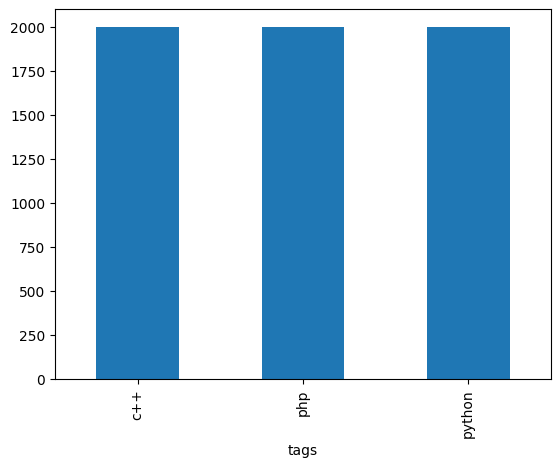

In [12]:
df['tags'].value_counts().sort_index().plot(kind='bar')

##### The data (tags col) is perfectly balanced. No need of undersampling or oversampling required moving forward. Total length of datatset is 6000 rows with 2000 rows for each unique categories (c++, php and python).

## Step 2: Process Data

  - Do preprocessing on your text to prepare it for the final machine learning model.

In [13]:
#clean data
df = df.dropna() # no missing values in the datatset
len(df)

6000

In [16]:
def clean_up(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    # lower case and stop word removal - optional but generally useful for classfication
    tokens = word_tokenize(text)
    stops = set(stopwords.words('english'))
    tokens = [token.lower() for token in tokens if token.isalpha()
          and token not in stops]
    text = ' '.join(tokens)
    return text.strip()

df['post'] = df['post'].apply(clean_up)
df = df[df['post'].str.len() > 50]
df.sample(2)

,post,tags
3263,uksort single digit integers treated larger do...,php
2552,call member function new php going stupid mist...,php


In [17]:
len(df) #12 rows removed since the length of its post was less than 50

5988

In [18]:
#split the data (80-20 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['post'], # X values
                                                    df['tags'], # Y values
                                                    test_size = 0.2, # test size
                                                    random_state = 42, # random shuffle
                                                    stratify = df['tags'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  4790
Size of Test Data  1198


## Step 3: Feature Extraction

- Use three different feature extraction methods.

## **1. TF-IDF**

In [19]:
#using TF-IDF as our feature extraction to compare classifiers
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tv_train = tfidf.fit_transform(X_train)
tv_test = tfidf.transform(X_test)

# make sure the second dimension matches (18651 matches)
tv_train.shape, tv_test.shape

((4790, 18651), (1198, 18651))

## **2. Word Embedding**

In [20]:
#Word Embedding
import numpy as np
def document_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        for word in words:
            if word in vocabulary:
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)
        return feature_vector
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [21]:
from gensim.models import Word2Vec
# train the model on the data
our_model = Word2Vec(X_train,
    vector_size = 500, #dimensions
    window = 5, #window size
    sg = 0, #cbow
    min_count = 1,
    workers = 4)

# generate averaged word vector features from word2vec model
avg_wv_train_features = document_vectorizer(corpus = X_train,
    model = our_model,
    num_features = 500)

# generate averaged word vector features from word2vec model
avg_wv_test_features = document_vectorizer(corpus = X_test,
    model = our_model,
    num_features = 500)

avg_wv_train_features.shape

(4790, 500)

##**3. Bag of Words**

In [22]:
# Bag of Words
count_vectorizer = CountVectorizer(max_features=1000)  # You can adjust the max_features as needed
cv_train = count_vectorizer.fit_transform(X_train)
cv_test = count_vectorizer.transform(X_test)
cv_train.shape, cv_test.shape

((4790, 1000), (1198, 1000))

## Step 4: Classification

- Use two classification algorithms with each feature extraction methods (e.g. build six models; two for each feature extraction method above).

# **1. Classification algorithms (using Logistic Regression and SVM) with TF-IDF feature extraction**

In [23]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(tv_train, Y_train)
y_log = logreg.predict(tv_test)

In [24]:
#SVM
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(tv_train, Y_train)
y_svm = svm.predict(tv_test)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


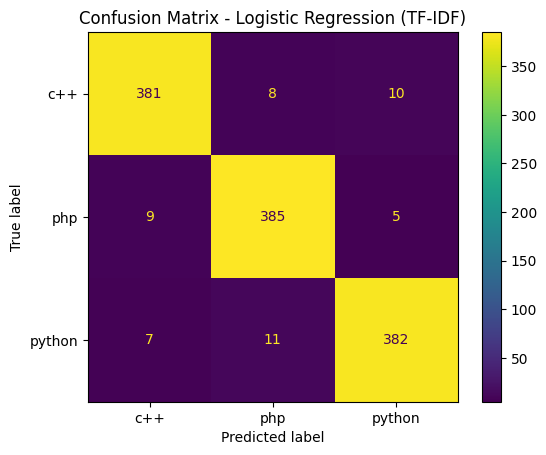

In [25]:
#Confusion Matrix - Logistic Regression (TF-IDF)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from matplotlib import pyplot as plt
cm = confusion_matrix(Y_test, y_log, labels = logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
        display_labels = logreg.classes_)
disp.plot()
plt.title('Confusion Matrix - Logistic Regression (TF-IDF)')
plt.show()

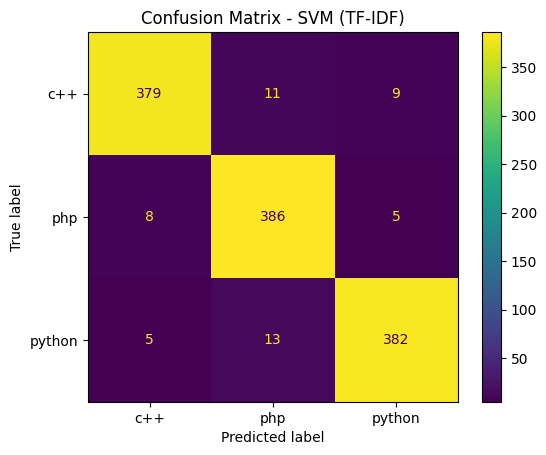

In [26]:
#Confusion Matrix - SVM (TF-IDF)
cm_svm = confusion_matrix(Y_test, y_svm, labels=svm.classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm.classes_)
disp_svm.plot()
plt.title('Confusion Matrix - SVM (TF-IDF)')
plt.show()

In [27]:
#Print Classification Report - Logistic Regression
from sklearn.metrics import classification_report
print("Classification Report - Logistic Regression (TF-IDF)")
print(classification_report(Y_test, y_log))

Classification Report - Logistic Regression (TF-IDF)
              precision    recall  f1-score   support

         c++       0.96      0.95      0.96       399
         php       0.95      0.96      0.96       399
      python       0.96      0.95      0.96       400

    accuracy                           0.96      1198
   macro avg       0.96      0.96      0.96      1198
weighted avg       0.96      0.96      0.96      1198



In [28]:
#Print Classification Report - SVM
print("Classification Report - SVM (TF-IDF)")
print(classification_report(Y_test, y_svm))

Classification Report - SVM (TF-IDF)
              precision    recall  f1-score   support

         c++       0.97      0.95      0.96       399
         php       0.94      0.97      0.95       399
      python       0.96      0.95      0.96       400

    accuracy                           0.96      1198
   macro avg       0.96      0.96      0.96      1198
weighted avg       0.96      0.96      0.96      1198



# **2. Classification algorithms (using Logistic Regression and SVM) with Word Embedding feature extraction**

In [29]:
# Logistic Regression
logreg = LogisticRegression(max_iter=10000)
logreg.fit(avg_wv_train_features, Y_train)
y_log_wv = logreg.predict(avg_wv_test_features)

In [30]:
#SVM
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(avg_wv_train_features, Y_train)
y_svm = svm.predict(avg_wv_test_features)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


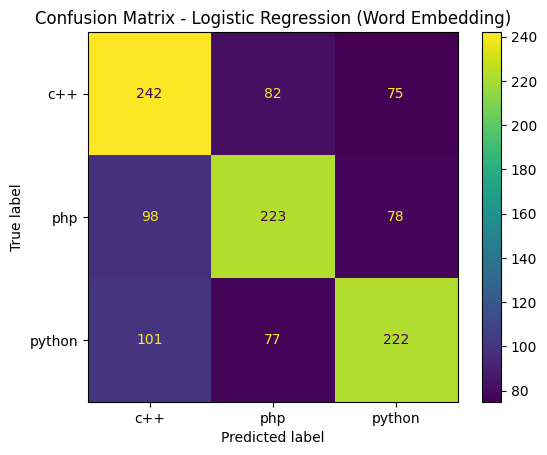

In [31]:
#Confusion Matrix - Logistic Regression (Word Embedding)
cm_log_wv = confusion_matrix(Y_test, y_log_wv, labels=logreg.classes_)
disp_log_wv = ConfusionMatrixDisplay(confusion_matrix=cm_log_wv, display_labels=logreg.classes_)
disp_log_wv.plot()
plt.title('Confusion Matrix - Logistic Regression (Word Embedding)')
plt.show()

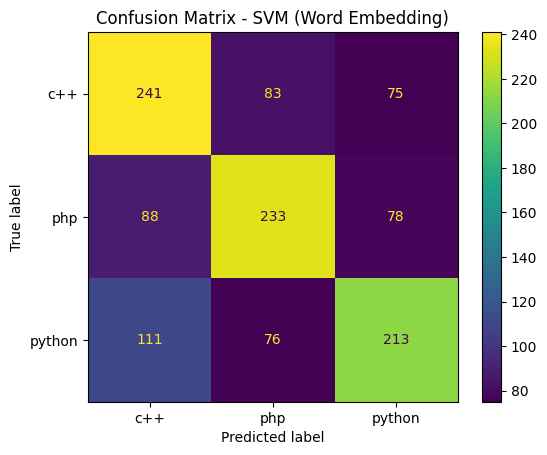

In [32]:
#Confusion Matrix - SVM (Word Embedding)
cm_svm_wv = confusion_matrix(Y_test, y_svm, labels=svm.classes_)
disp_svm_wv = ConfusionMatrixDisplay(confusion_matrix=cm_svm_wv, display_labels=svm.classes_)
disp_svm_wv.plot()
plt.title('Confusion Matrix - SVM (Word Embedding)')
plt.show()

In [33]:
print("Classification Report - Logistic Regression (Word Embedding)")
print(classification_report(Y_test, y_log_wv))

Classification Report - Logistic Regression (Word Embedding)
              precision    recall  f1-score   support

         c++       0.55      0.61      0.58       399
         php       0.58      0.56      0.57       399
      python       0.59      0.56      0.57       400

    accuracy                           0.57      1198
   macro avg       0.57      0.57      0.57      1198
weighted avg       0.57      0.57      0.57      1198



In [34]:
print("Classification Report - SVM (Word Embedding)")
print(classification_report(Y_test, y_svm))

Classification Report - SVM (Word Embedding)
              precision    recall  f1-score   support

         c++       0.55      0.60      0.57       399
         php       0.59      0.58      0.59       399
      python       0.58      0.53      0.56       400

    accuracy                           0.57      1198
   macro avg       0.57      0.57      0.57      1198
weighted avg       0.57      0.57      0.57      1198



# **3. Classification algorithms (using Logistic Regression and SVM) with Bag of Words feature extraction**

In [35]:
# Logistic Regression
logreg = LogisticRegression(max_iter=10000)
logreg.fit(cv_train, Y_train)
y_log_cv = logreg.predict(cv_test)

In [36]:
# SVM
svm = LinearSVC()
svm.fit(cv_train, Y_train)
y_svm = svm.predict(cv_test)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


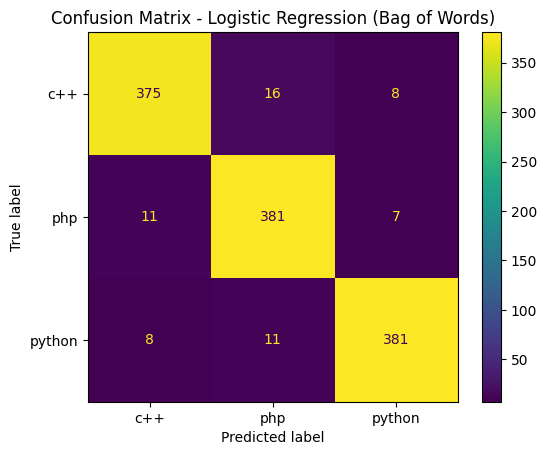

In [37]:
#Confusion Matrix - Logistic Regression (Bag of Words)
cm_log_cv = confusion_matrix(Y_test, y_log_cv, labels=logreg.classes_)
disp_log_cv = ConfusionMatrixDisplay(confusion_matrix=cm_log_cv, display_labels=logreg.classes_)
disp_log_cv.plot()
plt.title('Confusion Matrix - Logistic Regression (Bag of Words)')
plt.show()

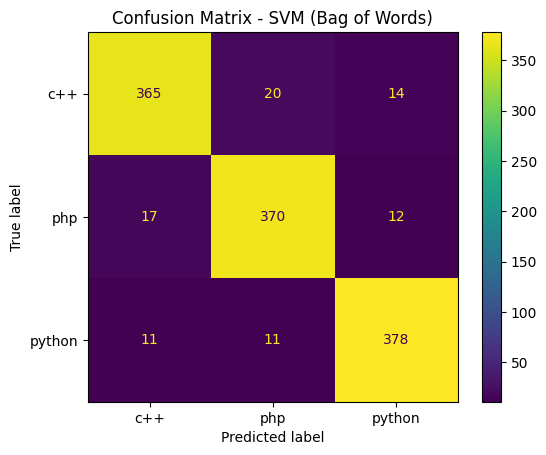

In [38]:
#Confusion Matrix - SVM (Bag of Words)
cm_svm_cv = confusion_matrix(Y_test, y_svm, labels=svm.classes_)
disp_svm_cv = ConfusionMatrixDisplay(confusion_matrix=cm_svm_cv, display_labels=svm.classes_)
disp_svm_cv.plot()
plt.title('Confusion Matrix - SVM (Bag of Words)')
plt.show()

In [39]:
print("Classification Report - Logistic Regression (Bag of Words)")
print(classification_report(Y_test, y_log_cv))

Classification Report - Logistic Regression (Bag of Words)
              precision    recall  f1-score   support

         c++       0.95      0.94      0.95       399
         php       0.93      0.95      0.94       399
      python       0.96      0.95      0.96       400

    accuracy                           0.95      1198
   macro avg       0.95      0.95      0.95      1198
weighted avg       0.95      0.95      0.95      1198



In [40]:
print("Classification Report - SVM (Bag of Words)")
print(classification_report(Y_test, y_svm))

Classification Report - SVM (Bag of Words)
              precision    recall  f1-score   support

         c++       0.93      0.91      0.92       399
         php       0.92      0.93      0.93       399
      python       0.94      0.94      0.94       400

    accuracy                           0.93      1198
   macro avg       0.93      0.93      0.93      1198
weighted avg       0.93      0.93      0.93      1198



## Interpretation

- Use eli5 OR lime to determine what predicts each category label.
- Write a paragraph summarizing the results from your comparisons. What models are best? Are there any general differences/similarities in prediction you see? How well is each category label classified? What might you do to make the model better?
  

In [41]:
#Prediction Probabilities
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(tv_train, Y_train) # new model on smaller data
y_log = logreg.predict(tv_test)
print(classification_report(Y_test, y_log))

              precision    recall  f1-score   support

         c++       0.96      0.95      0.96       399
         php       0.95      0.96      0.96       399
      python       0.96      0.95      0.96       400

    accuracy                           0.96      1198
   macro avg       0.96      0.96      0.96      1198
weighted avg       0.96      0.96      0.96      1198



In [42]:
probs = pd.DataFrame(logreg.predict_proba(tv_test), columns = ["c++", "php", "python"])
probs['answer'] = Y_test.reset_index(drop=True)
probs['text'] = X_test.reset_index(drop=True)
probs['predicted_cat'] = y_log
right_answers = probs[probs.answer == probs.predicted_cat]
## show DF
print(right_answers)

           c++       php    python  answer  \
0     0.954575  0.018514  0.026912     c++   
1     0.039504  0.040053  0.920443  python   
2     0.524181  0.250651  0.225168     c++   
3     0.838671  0.059351  0.101978     c++   
4     0.322592  0.561795  0.115612     php   
...        ...       ...       ...     ...   
1193  0.611105  0.091385  0.297509     c++   
1194  0.009580  0.045622  0.944798  python   
1195  0.856198  0.056801  0.087001     c++   
1196  0.057542  0.023947  0.918511  python   
1197  0.074124  0.021913  0.903963  python   

                                                   text predicted_cat  
0     cerr working wrote function takes two numbers ...           c++  
1     unpack list fewer variables k name view id tok...        python  
2     accessing encrypted archives want write passwo...           c++  
3     deallocate derived dynamic memory member say c...           c++  
4     best practices check constant array using php ...           php  
...            

In [43]:
#using coefficient
logreg.coef_.shape

(3, 18651)

In [44]:
tfidf.get_feature_names_out().shape

(18651,)

In [45]:
DF_coef = pd.DataFrame(logreg.coef_.T, columns = ["c++", "php", "python"])
DF_coef['words'] = tfidf.get_feature_names_out().T
print(DF_coef)

            c++       php    python   words
0      0.104131 -0.215487  0.111355      aa
1     -0.147217 -0.045678  0.192896     aaa
2     -0.020457  0.043414 -0.022957    aaaa
3     -0.095973  0.194119 -0.098146   aaaaa
4     -0.017229  0.032964 -0.015736  aaaaaa
...         ...       ...       ...     ...
18646  0.028325 -0.018682 -0.009643   цикла
18647 -0.010366 -0.012088  0.022454     что
18648  0.008684 -0.004007 -0.004678      एक
18649 -0.013060  0.028431 -0.015372      号码
18650  0.161400 -0.073889 -0.087511      한글

[18651 rows x 4 columns]


In [46]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(tfidf, logreg)
pipeline.predict_proba(["value initialization of inherited pod types  suppose the following:   <pre><code>struct pod1 { int a; }; struct pod2 : pod1 { int b; };  int main() {     pod2 p2 = pod2();     return 0; } </code></pre>  will both <code>p2.a</code> and <code>p2.b</code> equal 0 after <code>p2</code> is defined  basically i m not sure if the value initialization rules also apply to base classes of pod types."])

array([[0.91856231, 0.0299764 , 0.05146129]])

In [47]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names = Y_train.sort_values().unique())

id_values = [1,14,435,550,755]
for id_value in id_values:
  print('Document id: %d' % id_value)
  print('Predicted class =', right_answers.iloc[id_value]["predicted_cat"])
  print('True class: %s' % right_answers.iloc[id_value]["answer"])
  print(right_answers.iloc[id_value]['text'])

Document id: 1
Predicted class = python
True class: python
unpack list fewer variables k name view id tokens k traceback recent call last file line valueerror many values unpack need provide variables unpack list way unpack fewer tokens gets rest list want write another line append list thanks course slice list assign individually etc want know want using syntax
Document id: 14
Predicted class = php
True class: php
split digit php achieve number seperately given variable store php function
Document id: 435
Predicted class = php
True class: php
variable value types simple question variable type php two values array row type float one decimal like row type float one decimal like actually try make calculation row row row need integer without point like result two decimal like tried way dsf row conf row dsf echo conf returns wrong result example row change format change row conf something around number expect get change format using conf instead program return number wrong
Document id: 550

#### For Document id 755, the predicted and true class both are "php". The model has labelled this row as 'php' because of few features like 'php','database','function' etc in it.

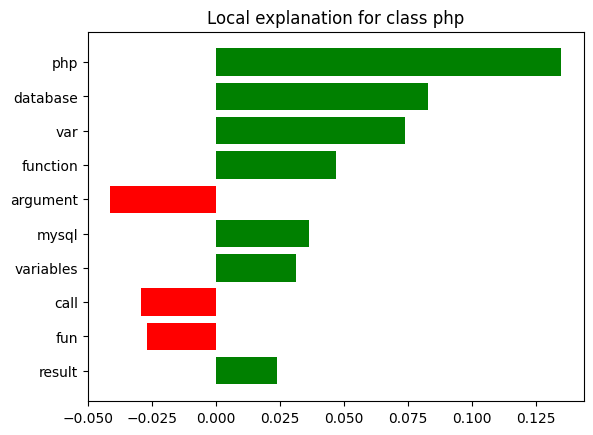

In [48]:
exp = explainer.explain_instance(right_answers.iloc[755]["text"],
      pipeline.predict_proba, num_features=10)

exp.as_pyplot_figure()
plt.show()

In [49]:
exp.save_to_file('example.html')

### Lime
Lime is a package that helps us explain models. Lime allows to actually give new data and see what probabilities will it give to new cases. It interpret the predictions by highlighting which features (in this case, words or tokens) are most influential for a given prediction.

The chart above shows that certain features like -

*   'php', 'database', 'var', and others -> strong indicators that the instance belongs to the "php" class (green bars)
*   'argument', 'call', 'fun' -> decrease the probability that the instance is classified as "php" (red bars). Maybe they might be more related "python" or "c++" labels.


## Write a paragraph summarizing the results from your comparisons. What models are best? Are there any general differences/similarities in prediction you see? How well is each category label classified? What might you do to make the model better?

The comparison results show differences in performance depending on the feature extraction method used.

1. When using TF-IDF, both Logistic Regression and SVM classifiers perform remarkably well across all categories (C++, PHP, Python), with precision, recall, and F1-scores mostly around 0.96. This suggests that TF-IDF effectively captures the key features of the data.

2. The Bag of Words method also performs strongly, though slightly behind TF-IDF, with F1-scores ranging from 0.93 to 0.95 for both classifiers.

3. On the other hand, the Word Embedding method underperforms, with F1-scores around 0.54 to 0.58, indicating it may not be suitable for this particular task.

From the result of confusion matrix (Log) using TF-IDF feature extraction process, it is worth noting that 381, 385 and 382 texts have been correctly predicted by the model as c++, python and php tags respectively.

Between Logistic Regression and SVM, the results indicate that both models perform similarly well when using TF-IDF and Bag of Words feature extraction methods, with minimal differences in their precision, recall, and F1-scores. However, the SVM model shows a slight edge in performance with TF-IDF, achieving marginally higher precision and recall values, especially for the C++ category. Therefore, if choosing the best model based solely on these results, the SVM with TF-IDF feature extraction appears to be the best performing combination.

To improve the models, exploring alternative feature extraction techniques could be used, further tuning hyperparameters of models used here (logistic regression and SVM) could have been done, more supervised ML models could have been also implemeted here except logistic and SVM (like naive bayes, decision tree etc), ensembling techniques could also have been used (which is combining features of multiple ML models). Moreover, there was no need of over/under sampling in our case because the dependent label 'tags' was uniformly distributed between it's three categories (c++, python and php).

## Step 6: Application

## Describe some real-world application that could use the techniques from this section. Define a problem or question, what data would be needed, how the data would be analyzed, and what insights/solutions could be drawn from the analysis.

- Real-world application: Sentiment analysis in customer reviews
(Some more application could be - Healthcare Sentiment Analysis, Social media monitoring).

- Problem: A retail company wants to analyze customer reviews to understand their sentiments about different products. The goal here is to classify reviews as positive, negative, or neutral automatically, thus understanding insights into customer satisfaction.

- Data Needed: The data could contain multiple columns like demographic details about the customers, such as age, gender, and location. Metadata related to the reviewed products, including product category, price, and specifications. Text reviews from customers, each marked with the sentiment expressed—positive, negative, or neutral.

- Data Analysis: Data Analysis (Pre-processing) is a vital step to build any ML model on the data. Few steps which are required to be followed after loading the dataset are:
1. Creating a summary of the dataset (how many labels are there in dependent column, whether it's balanced or unbalanced).
2. Cleaning the dataset (concatenating, dropping columns removing null rows, removing irrelevant tags & punctuation from text, removing stops words (or if stop words are important then can do stemming/lemmatization or both as req)
3. Splitting the dataset (mostly 80-20 is the split ratio between train-test but it could vary depending upon the length of the dataset).
4. Using feature extraction techniques to convert text to numbers. There are multiple feature extraction techniques like TF-IDF, Bag of words, Doc2Text, Word Embedding etc (of all TF-IDF could be considered the best in majority of cases).
5. After feature extraction, different supervised ML models (supervised since our data has the dependent field (which is reviews here)) could be implemented and it's performance could be evaluated (again there are multiple metrics to access the model's performance like accuracy, precision etc.).

- Insights/solutions:
1. Helps the company understand overall sentiments about its products, determining what customers like or dislike.
2. Identify issues from negative reviews to make informed decisions on product improvements.
3. Use positive reviews to highlight strengths in marketing campaigns.







